In [2]:
require 'distribution'
require 'narray'
require 'daru'
require 'gnuplotrb'
include Daru
include GnuplotRB
include Fit
nil

"if(window['d3'] === undefined ||\n   window['Nyaplot'] === undefined){\n    var path = {\"d3\":\"https://cdnjs.cloudflare.com/ajax/libs/d3/3.5.5/d3.min\",\"downloadable\":\"http://cdn.rawgit.com/domitry/d3-downloadable/master/d3-downloadable\"};\n\n\n\n    var shim = {\"d3\":{\"exports\":\"d3\"},\"downloadable\":{\"exports\":\"downloadable\"}};\n\n    require.config({paths: path, shim:shim});\n\n\nrequire(['d3'], function(d3){window['d3']=d3;console.log('finished loading d3');require(['downloadable'], function(downloadable){window['downloadable']=downloadable;console.log('finished loading downloadable');\n\n\tvar script = d3.select(\"head\")\n\t    .append(\"script\")\n\t    .attr(\"src\", \"http://cdn.rawgit.com/domitry/Nyaplotjs/master/release/nyaplot.js\")\n\t    .attr(\"async\", true);\n\n\tscript[0][0].onload = script[0][0].onreadystatechange = function(){\n\n\n\t    var event = document.createEvent(\"HTMLEvents\");\n\t    event.initEvent(\"load_nyaplot\",false,false);\n\t    win

# Variables

In [11]:
prefix="20160222"

input_doas = "../DOAS/#{prefix}_NO.csv"
input_cld = "../CLD/#{prefix}.csv"
output_corr = "../#{prefix}_corr.csv"
img_corr = "../images/#{prefix}_corr.png"

remove_cld_zeros = false
zero_eps = 0.05
zero_location = 0.8

#order_doas = ["timestamp", "no"]
#order_cld = order_doas
nil

# DOAS Preparation

In [5]:
data = Daru::DataFrame.from_csv(input_doas)
data.vectors = Index.new(data.vectors.to_a.map{|i| i.to_sym})
data.index = DateTimeIndex.new(data[:timestamp])
data.head

,h2o,h2o_err,index,no,no2,no2_err,nox,nox_err,o3,o3_err,timestamp
2016-02-22T10:42:44+01:00,3665141.91075972,925594.721589852,0,,7.95658889551521,0.0653100505114418,,,35.5115197644284,1149.0426000682,2016-02-22T10:42:44+01:00
2016-02-22T10:43:55+01:00,3903930.77976969,1503851.60074163,1,3.9590544192544943,,,16.2566628142127,0.107415206400888,2882.62884809316,1866.32015106246,2016-02-22T10:43:55+01:00
2016-02-22T10:45:06+01:00,4366542.36753126,1486963.22039045,2,,16.6386278944012,0.106270597308685,,,-928.749504463599,1845.33478910489,2016-02-22T10:45:06+01:00
2016-02-22T10:46:16+01:00,4272829.70240693,1595428.677505,3,1.640772118722932,,,17.7000032436948,0.114207158635106,2587.18198061541,1979.87702335278,2016-02-22T10:46:16+01:00
2016-02-22T10:47:27+01:00,4241770.73354746,1428662.5383808,4,,15.4715572588364,0.101923822698394,,,-577.403950806126,1773.10058674671,2016-02-22T10:47:27+01:00
2016-02-22T10:48:38+01:00,3828249.81785127,1398915.48322694,5,1.694475971827469,,,14.5806201843574,0.0996676260001644,2438.65996647698,1736.17221507061,2016-02-22T10:48:38+01:00
2016-02-22T10:49:48+01:00,4082024.36935253,1079010.93990976,6,,10.3371454344813,0.0763960025413429,,,-530.046244473469,1339.39057402859,2016-02-22T10:49:48+01:00
2016-02-22T10:50:59+01:00,3642236.38805852,1049970.59091174,7,0.27763876548465305,,,9.31928458200006,0.074230481187959,2828.66443510416,1303.36096429051,2016-02-22T10:50:59+01:00
2016-02-22T10:52:09+01:00,3313757.52455168,947529.411157991,8,,7.76439267204199,0.0668392742041499,,,-557.083679993495,1176.23377661221,2016-02-22T10:52:09+01:00
2016-02-22T10:53:20+01:00,3716648.02787163,905867.763635704,9,-0.38115356718257054,,,7.61290572865782,0.0638867897065253,2541.13329136179,1124.5537823362,2016-02-22T10:53:20+01:00


In [22]:
start = Time.at((data[:timestamp].first.to_time.to_f/(60*30)).floor*(60*30)).to_datetime
stop = start + 1.0/48
format = "%Y-%m-%d %H:%M:%S%:z"

time = []
mean = []

while (start < data[:timestamp].to_a.last) do 
  sstart = start.strftime(format)
  sstop = stop.strftime(format)
  
  mean << data.row[sstart..sstop][:no].mean
  time << sstart
  
  start = stop
  stop += 1.0/48
end

doas = Daru::DataFrame.new({timestamp: time, mean: mean}, order: [:timestamp, :mean], 
  index: DateTimeIndex.new(time))
doas.head

,timestamp,mean
2016-02-22T10:30:00+01:00,2016-02-22T10:30:00+01:00,0.962425307004556
2016-02-22T11:00:00+01:00,2016-02-22T11:00:00+01:00,0.7715371801027994
2016-02-22T11:30:00+01:00,2016-02-22T11:30:00+01:00,0.10098075639065246
2016-02-22T12:00:00+01:00,2016-02-22T12:00:00+01:00,3.1289812324782966
2016-02-22T12:30:00+01:00,2016-02-22T12:30:00+01:00,1.2036139578985487
2016-02-22T13:00:00+01:00,2016-02-22T13:00:00+01:00,1.466855146097322
2016-02-22T13:30:00+01:00,2016-02-22T13:30:00+01:00,0.2095925177217333
2016-02-22T14:00:00+01:00,2016-02-22T14:00:00+01:00,0.2542373367004655
2016-02-22T14:30:00+01:00,2016-02-22T14:30:00+01:00,0.21874704421971397
2016-02-22T15:00:00+01:00,2016-02-22T15:00:00+01:00,0.5445268145077211


# CLD Preparation
Kalibration ausgelagert

In [24]:
data2 = DataFrame.from_csv(input_cld)
data2.vectors = Index.new(data2.vectors.to_a.map{|i| i.to_sym})
data2.index = DateTimeIndex.new(data2[:timestamp])
data2.head

,no,timestamp
2016-02-22T00:00:21+01:00,0.7907632480188918,2016-02-22T00:00:21+01:00
2016-02-22T00:00:43+01:00,0.7907632480188918,2016-02-22T00:00:43+01:00
2016-02-22T00:01:05+01:00,0.7907632480188918,2016-02-22T00:01:05+01:00
2016-02-22T00:01:28+01:00,0.7907632480188918,2016-02-22T00:01:28+01:00
2016-02-22T00:01:50+01:00,0.8495062649427549,2016-02-22T00:01:50+01:00
2016-02-22T00:02:12+01:00,0.7907632480188918,2016-02-22T00:02:12+01:00
2016-02-22T00:02:34+01:00,0.7907632480188918,2016-02-22T00:02:34+01:00
2016-02-22T00:02:57+01:00,0.7907632480188918,2016-02-22T00:02:57+01:00
2016-02-22T00:03:19+01:00,0.7907632480188918,2016-02-22T00:03:19+01:00
2016-02-22T00:03:41+01:00,0.7907632480188918,2016-02-22T00:03:41+01:00


In [25]:
start = Time.at((data2[:timestamp].first.to_time.to_f/(60*30)).floor*(60*30)).to_datetime
stop = start + 1.0/48
format = "%Y-%m-%d %H:%M:%S%:z"

time = []
mean = []

while (start < data[:timestamp].to_a.last) do 
  sstart = start.strftime(format)
  sstop = stop.strftime(format)

  mean << data2.row[sstart..sstop][:no].mean
  time << sstart
  
  start = stop
  stop = stop + 1.0/48
end

cld = Daru::DataFrame.new({timestamp: time, mean: mean}, order: [:timestamp, :mean],
  index: DateTimeIndex.new(time))
cld.head

,timestamp,mean
2016-02-22T00:00:00+01:00,2016-02-22T00:00:00+01:00,0.8164633179230811
2016-02-22T00:30:00+01:00,2016-02-22T00:30:00+01:00,0.8589341565478191
2016-02-22T01:00:00+01:00,2016-02-22T01:00:00+01:00,0.8734386051709954
2016-02-22T01:30:00+01:00,2016-02-22T01:30:00+01:00,0.871534896289203
2016-02-22T02:00:00+01:00,2016-02-22T02:00:00+01:00,0.8785151621891067
2016-02-22T02:30:00+01:00,2016-02-22T02:30:00+01:00,0.7907632480188911
2016-02-22T03:00:00+01:00,2016-02-22T03:00:00+01:00,0.798106125134374
2016-02-22T03:30:00+01:00,2016-02-22T03:30:00+01:00,0.7943893601746851
2016-02-22T04:00:00+01:00,2016-02-22T04:00:00+01:00,0.7914884704500499
2016-02-22T04:30:00+01:00,2016-02-22T04:30:00+01:00,0.7922136928812087


# Correlation build and plot

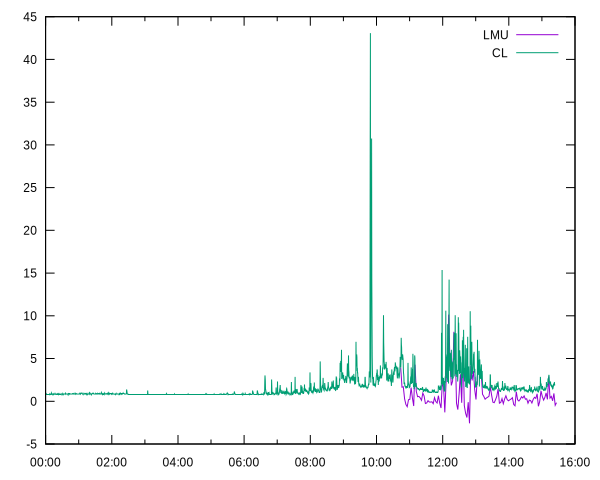

In [26]:
data.index = DateTimeIndex.new(data[:timestamp].to_a)
data2.index = DateTimeIndex.new(data2[:timestamp].to_a)

GnuplotRB::Plot.new(
  [data[:no], with: "lines", title: "DOAS"],
  [data2[:no], with: "lines", title: "CL"],
  format_x: "%H:%M"
  )

# Remove CLD zeros

In [27]:
if remove_cld_zeros
  cld = cld.where(
    cld[:mean].map do |m|
      ret = true
    
      if (m - zero_location).abs < zero_eps
        ret = false
      end
      ret
    end)
end

In [28]:
corr = doas.join(cld, on: [:timestamp], how: :inner)

,mean_1,timestamp,mean_2
0,0.962425307004556,2016-02-22T10:30:00+01:00,3.3109111962957383
1,0.7715371801027994,2016-02-22T11:00:00+01:00,1.9010787901230217
2,0.10098075639065246,2016-02-22T11:30:00+01:00,1.541368464268254
3,3.1289812324782966,2016-02-22T12:00:00+01:00,4.402370955189739
4,1.2036139578985487,2016-02-22T12:30:00+01:00,3.9164719263133394
5,1.466855146097322,2016-02-22T13:00:00+01:00,2.3702977030827688
6,0.2095925177217333,2016-02-22T13:30:00+01:00,1.5261387932139199
7,0.2542373367004655,2016-02-22T14:00:00+01:00,1.4521661052357215
8,0.21874704421971397,2016-02-22T14:30:00+01:00,1.3810943069821586
9,0.5445268145077211,2016-02-22T15:00:00+01:00,1.8297803598597215


In [29]:
corr.write_csv(output_corr)

In [30]:
corr_plot = GnuplotRB::Plot.new(
  [corr, using: "2:4", title: "", pt: 6, ps: 1],
  xlabel: "DOAS [ppb]",
  ylabel: "CL [pbb]"
  )
nil

In [31]:
fit = fit_poly(corr, degree: 1, using: "2:4")
fit[:formula_ds].data

" 1.44191*x**0 + 1.03962*x**1 "

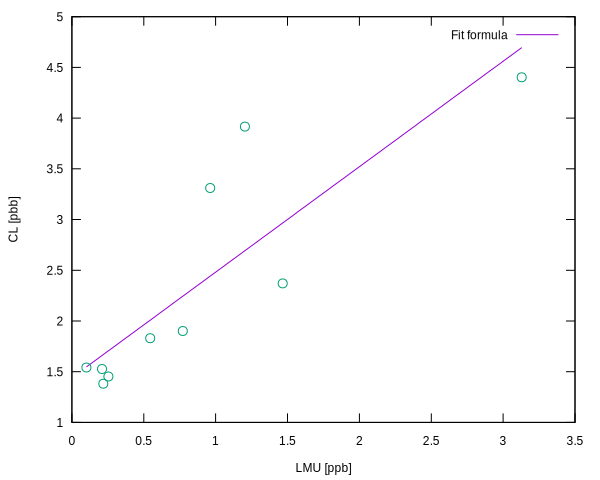

In [32]:
(corr_plot << fit[:formula_ds]).to_png(img_corr)